# Transfer learning to predict COVID-19

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential, Input
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from covid_flu import config, utils, time_series, plotting, models

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Introduction

In this notebook, we will attempt to take the work we have done previously on predicting seasonal influenza using RNNs and apply it to COVID-19 through the use of transfer learning.

#### Transfer learning

As already seen in our notebook exploring how RNNs can be used to predict flu (found [here](#)), these kinds of algorithms can be quite effective for even long-term predictions. However, a major limitation of sequence-to-sequence (seq2seq) models, and many powerful ML algorithms more broadly, is that they require a large amount of data. This is because the number of parameters (weights) can run into the tens of thousands even for simple models, let alone massive models with hundreds of millions of parameters.

One way to deal with the problem of data scarcity is transfer learning (TL). This is a deceptively simple technique whereby a model $M$ that has been trained using dataset $D$ for task $T$ is then re-used, entirely or in part, with fine-tuning or as-is, for another dataset $D'$ and/or task $T'$. For instance, in AC209b, we used a pre-trained MobileNet CNN to perform image classification.

There are several ways to do TL and which one we use depends heavily on two factors:

* How different our dataset $D'$ is from the dataset the model was trained on $D$
* How different our task $T'$ is from the task the model was trained on $T'$

If the tasks $T$ and $T'$ are very different, then it is likely necessary to modify the model architecture. In the case of a CNN trained for image classification, it is common practice to freeze the convolutional part, which can be seen as a feature extractor, and to change the fully connected network (FCN), which can be seen as a classifier. For some large pre-trained models, such as ImageNet or MobileNet, the convolutional base can be sufficiently complex to extract a rich enough set of features for a new FCN head to work with. This is referred to as *representation learning* -- using a neural network to convert the input into an abstract representation that is more useful for downstream tasks.

If datasets $D$ and $D'$ are very different, but $T$ and $T'$ are similar, then it is likely sufficient to fine-tune part or all of the model, while maintaining the same architecture.

In general, the more similar $D$ and $D'$, as well as $T$ and $T'$, then the more successful TL is likely to be.

#### Problem formulation

We have the following two datasets:

* $D$ = Reported weekly seasonal influenza cases from the last 10 years in the United States
* $D'$ = Reported daily COVID-19 cases from the beginning of 2020 in the United States

We have only one task: univariate time series forecasting.

We will attempt to apply TL by using a model trained on the flu data and then transferring it to COVID-19 data.

#### Outline of notebook

1. Data loading and preparation
2. Training seq2seq model on influenza
3. Transferring seq2seq model to COVID-19
    1. No TL
    2. Fine-tuning just the FCN head
    3. Fine-tuning the entire model

## Preparing data

In [2]:
df_flu = utils.load_flu_data()
df_covid = utils.load_covid_data()
display(df_flu.head())
display(df_covid.head())

,time,wili,state
0,2010-40,2.06514,Texas
1,2010-41,2.09394,Texas
2,2010-42,2.10072,Texas
3,2010-43,2.20655,Texas
4,2010-44,2.36381,Texas


,date,state,cases,total_cases
0,2020-01-21,Alabama,0.0,0.0
1,2020-01-22,Alabama,0.0,0.0
2,2020-01-23,Alabama,0.0,0.0
3,2020-01-24,Alabama,0.0,0.0
4,2020-01-25,Alabama,0.0,0.0


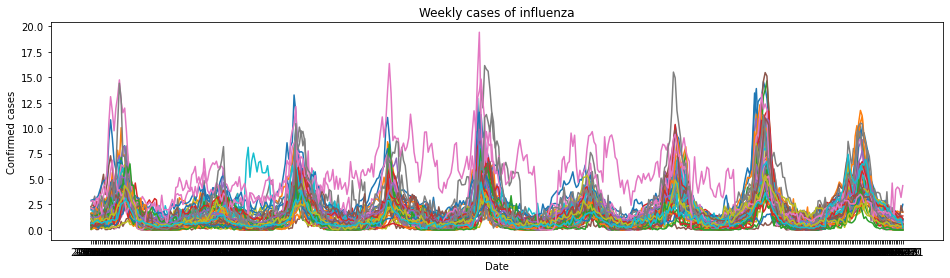

In [3]:
plt.figure(figsize=(16, 4))
plt.title("Weekly cases of influenza")
for state in df_flu['state'].unique():
    subset = df_flu.query('state == @state')
    plt.plot(subset['time'], subset['wili'])
plt.ylabel("Confirmed cases")
plt.xlabel("Date")
plt.show()

For much of the year, there are no reported cases. Because we will be splitting data using a cutoff date (before and after) rather than a random train/test/val split, we don't want most of the training data to have very low case counts.

In [4]:
df_covid = df_covid[df_covid['total_cases'] >= 10]

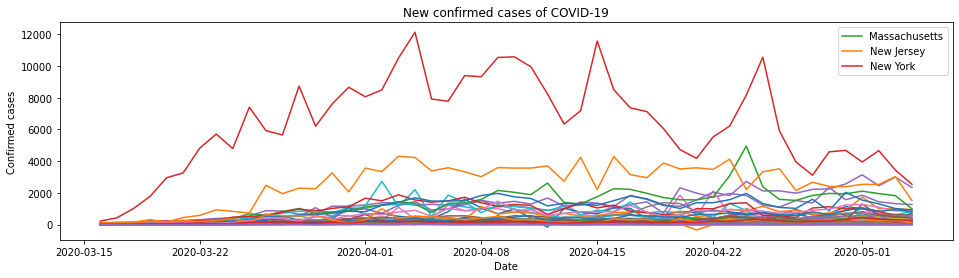

In [5]:
plt.figure(figsize=(16, 4))
plt.title("New confirmed cases of COVID-19")
for state in df_covid['state'].unique():
    subset = df_covid.query('state == @state').query('date > @pd.to_datetime("2020-03-15")')
    if (subset['cases'] > 4000).any():
        plt.plot(subset['date'], subset['cases'], label=state)
    else:
        plt.plot(subset['date'], subset['cases'])
plt.ylabel("Confirmed cases")
plt.xlabel("Date")
plt.legend()
plt.show()

#### Notable differences between the two datasets

The flu and COVID-19 datasets might be alike in that they are both diseases that are quite contagious and can follow exponential growth trends, it is evidence from the two time series that they are both quite different in terms of their progression in the population. There are also important differences between the datasets themselves, irrespective of the underlying diseases.

* **Temporal resolution**: Flu data are collected weekly, allowing for more shap differences between individual time points, whereas COVID data are reported daily
* **Trajectory**: The flu tends to follow a pattern of steep peaks spaced out by wide troughs, which repeats throughout the year. COVID, on the other hand, exhibits a slow and steady
* **Completeness**: The flu data cover 10 years completely, whereas the COVID data do not even cover half a year. Thus, the patterns that might be noticed in the flu data are not available for forecasting COVID.

These differences will need to be mitigated where possible or accepted as limitations in this methodology. Later on, we will attempt to mitigate the effect of the first (temporal resolution) whereas the other two are likely better dealt with through more parametric methods (such as agent-based models).

## Preprocessing data

In [6]:
# Some hyperparameters
HISTORY_SIZE = 25
TARGET_SIZE = 5
BATCH_SIZE = 64
TEST_SIZE = 0.3
EPOCHS = 20

In [7]:
# Scaling
scaler_flu = StandardScaler()
scaler_covid = StandardScaler()
df_flu['wili'] = utils.scale_data(df_flu['wili'].values, scaler_flu)
df_covid['cases'] = utils.scale_data(df_covid['cases'].values, scaler_covid)

In [8]:
# Preparing tensorflow datasets
# Making train/val/test split
ds_train_flu, ds_val_flu, ds_test_flu, data_dict_flu = time_series.prepare_data(df_flu['wili'].values, 
                                                                                df_flu['state'].values,
                                                                                history_size=HISTORY_SIZE,
                                                                                target_size=TARGET_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                test_size=TEST_SIZE,
                                                                                teacher_forcing=True)

ds_train_covid, ds_val_covid, ds_test_covid, data_dict_covid = time_series.prepare_data(df_covid['cases'].values, 
                                                                                        df_covid['state'].values,
                                                                                        history_size=HISTORY_SIZE,
                                                                                        target_size=TARGET_SIZE,
                                                                                        batch_size=BATCH_SIZE,
                                                                                        test_size=TEST_SIZE,
                                                                                        teacher_forcing=True)

## Building a seq2seq model for flu

Building on the work in our RNN notebook that focused entirely on flu, we use a seq2seq RNN consisting of a 3-layer LSTM encoder and a 1-layer decoder. We train using teacher forcing, where the decoder predicts a single point at a time and the next point fed to the decoder is the true value of the time series, rather than what was predicted on the previous step.

In [9]:
NUM_ENCODER_LAYERS = 2
HIDDEN_SIZE = 16
PRE_OUTPUT_DENSE_SIZE = 16

In [10]:
seq2seq_model = models.Seq2Seq(history_length=HISTORY_SIZE,
                               target_length=TARGET_SIZE,
                               hidden_size=HIDDEN_SIZE,
                               pre_output_dense_size=PRE_OUTPUT_DENSE_SIZE,
                               num_encoder_layers=NUM_ENCODER_LAYERS)
seq2seq_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 16), (No 1152        input_1[0][0]                    
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 25, 16), (No 2112        encoder_lstm0[0][0]              
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32)           0           encoder_lstm1[0][1]              
                                                                 encoder_lstm1[0][2]          

In [11]:
history_flu = seq2seq_model.fit(ds_train_flu, validation_data=ds_val_flu, epochs=EPOCHS)

Train for 236 steps, validate for 51 steps
Epoch 1/20
236/236 [==============================] - 17s 70ms/step - loss: 0.2675 - val_loss: 0.1242
Epoch 2/20
236/236 [==============================] - 8s 36ms/step - loss: 0.1162 - val_loss: 0.0915
Epoch 3/20
236/236 [==============================] - 10s 41ms/step - loss: 0.1032 - val_loss: 0.0847
Epoch 4/20
236/236 [==============================] - 11s 46ms/step - loss: 0.0996 - val_loss: 0.0833
Epoch 5/20
236/236 [==============================] - 9s 36ms/step - loss: 0.0985 - val_loss: 0.0816
Epoch 6/20
236/236 [==============================] - 9s 37ms/step - loss: 0.0971 - val_loss: 0.0831
Epoch 7/20
236/236 [==============================] - 9s 36ms/step - loss: 0.0957 - val_loss: 0.0809
Epoch 8/20
236/236 [==============================] - 8s 33ms/step - loss: 0.0953 - val_loss: 0.0807
Epoch 9/20
236/236 [==============================] - 9s 36ms/step - loss: 0.0944 - val_loss: 0.0780
Epoch 10/20
236/236 [========================

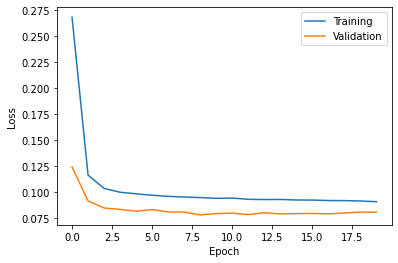

In [12]:
plotting.plot_history(history_flu)

In [13]:
states = ['New York', 'California', 'Texas', 'Colorado', 'Washington']

def plot_example_states(states, model, data_dict, scaler, pred_window=5, state2idx=None):
    fig, axs = plt.subplots(len(states), 3, figsize=(3.5 * len(states), 16))
    for i, state in enumerate(states):
        for j, split in enumerate(['train', 'val', 'test']):
            plotting.plot_seq2seq_preds(model, data_dict, state,
                                        pred_window, scaler=scaler_flu,
                                        split=split, ax=axs[i, j],
                                        state2idx=state2idx)
            axs[i, j].set_title(state)
    plt.show()

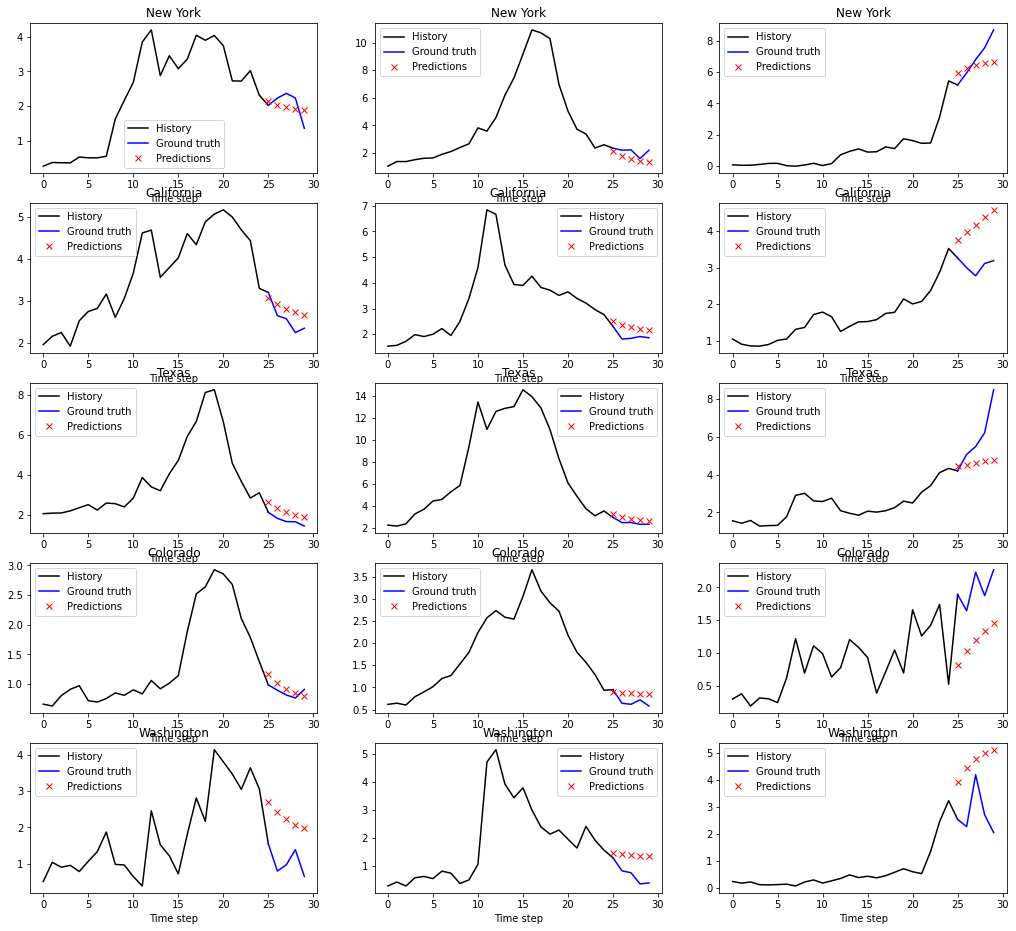

In [14]:
plot_example_states(states, seq2seq_model, data_dict_flu, scaler_flu)

Unfortunately, the results are not particularly encouraging for the flu model. It does not appear as though the model is very good at picking up on small micro-trends and fluctuations in the number of influenza cases, beyond what a simple moving average or autoregressive model could do. However, it is possible that the model might still be good for COVID, since the COVID time series shows less cyclical spikes and more constant increases

## Transfer learning

We will try to model COVID in three ways:

1. Identical model to flu, training from scratch
2. The flu model without any retraining
3. The flu model with the FCN head fine-tuned

### Training from scratch

In [15]:
seq2seq_covid_scratch = models.Seq2Seq(history_length=HISTORY_SIZE,
                               target_length=TARGET_SIZE,
                               hidden_size=HIDDEN_SIZE,
                               pre_output_dense_size=PRE_OUTPUT_DENSE_SIZE,
                               num_encoder_layers=NUM_ENCODER_LAYERS)
seq2seq_covid_scratch.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 16), (No 1152        input_5[0][0]                    
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 25, 16), (No 2112        encoder_lstm0[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32)           0           encoder_lstm1[0][1]              
                                                                 encoder_lstm1[0][2]        

In [16]:
history_cov_scratch = seq2seq_covid_scratch.fit(ds_train_covid, validation_data=ds_val_covid, epochs=EPOCHS)

Train for 14 steps, validate for 4 steps
Epoch 1/20
14/14 [==============================] - 6s 400ms/step - loss: 2.0125 - val_loss: 0.7837
Epoch 2/20
14/14 [==============================] - 1s 36ms/step - loss: 1.8350 - val_loss: 0.5486
Epoch 3/20
14/14 [==============================] - 1s 36ms/step - loss: 1.5630 - val_loss: 0.4760
Epoch 4/20
14/14 [==============================] - 1s 36ms/step - loss: 1.3326 - val_loss: 0.2982
Epoch 5/20
14/14 [==============================] - 0s 35ms/step - loss: 1.1184 - val_loss: 0.1573
Epoch 6/20
14/14 [==============================] - 1s 37ms/step - loss: 0.9100 - val_loss: 0.1871
Epoch 7/20
14/14 [==============================] - 1s 36ms/step - loss: 0.7528 - val_loss: 0.1258
Epoch 8/20
14/14 [==============================] - 0s 35ms/step - loss: 0.6384 - val_loss: 0.1143
Epoch 9/20
14/14 [==============================] - 0s 35ms/step - loss: 0.5066 - val_loss: 0.1069
Epoch 10/20
14/14 [==============================] - 0s 35ms/step -

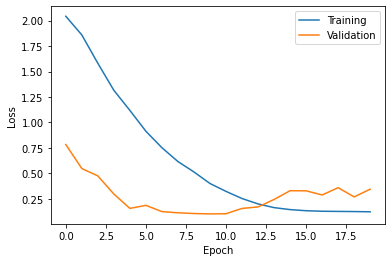

In [17]:
plotting.plot_history(history_cov_scratch)

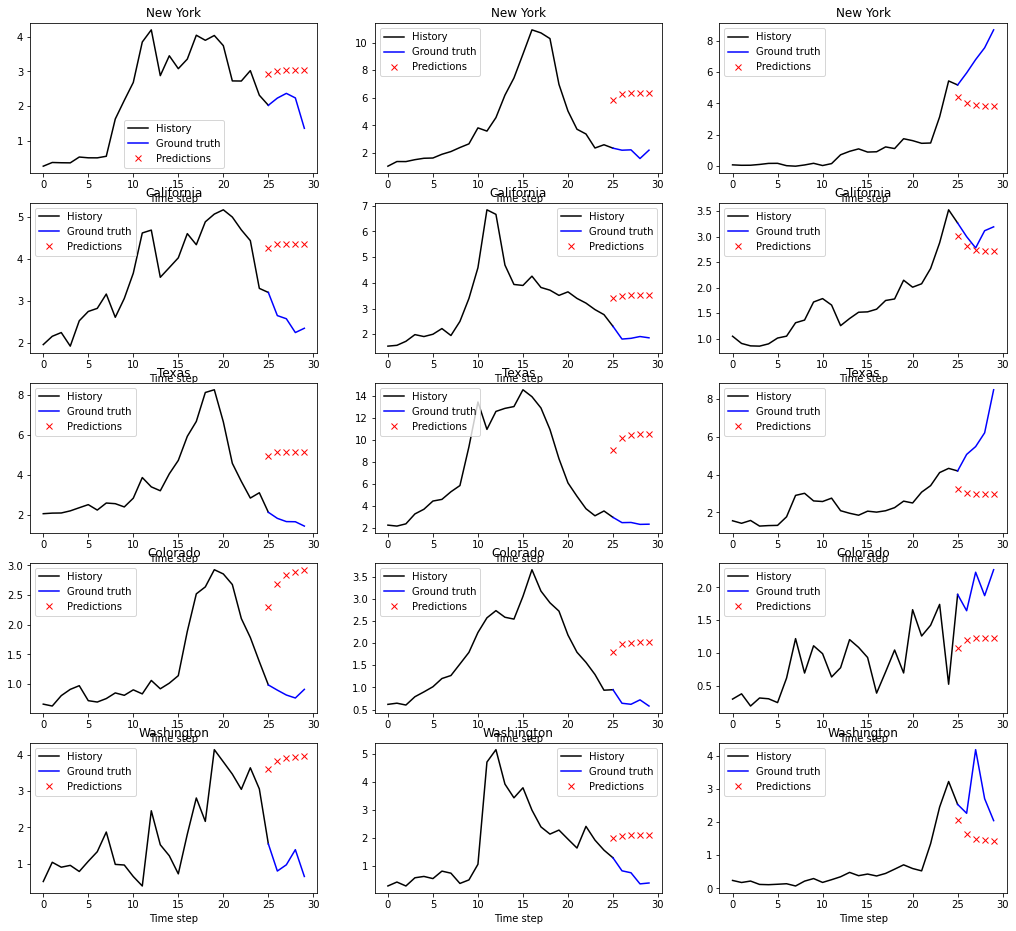

In [18]:
plot_example_states(states, seq2seq_covid_scratch, data_dict_flu, scaler_covid)

These results are quite poor. As evident from the plot of the loss, while the training loss goes does the validation loss barely moves. Let's compare against the original, untuned flu model.

### Just using the flu model

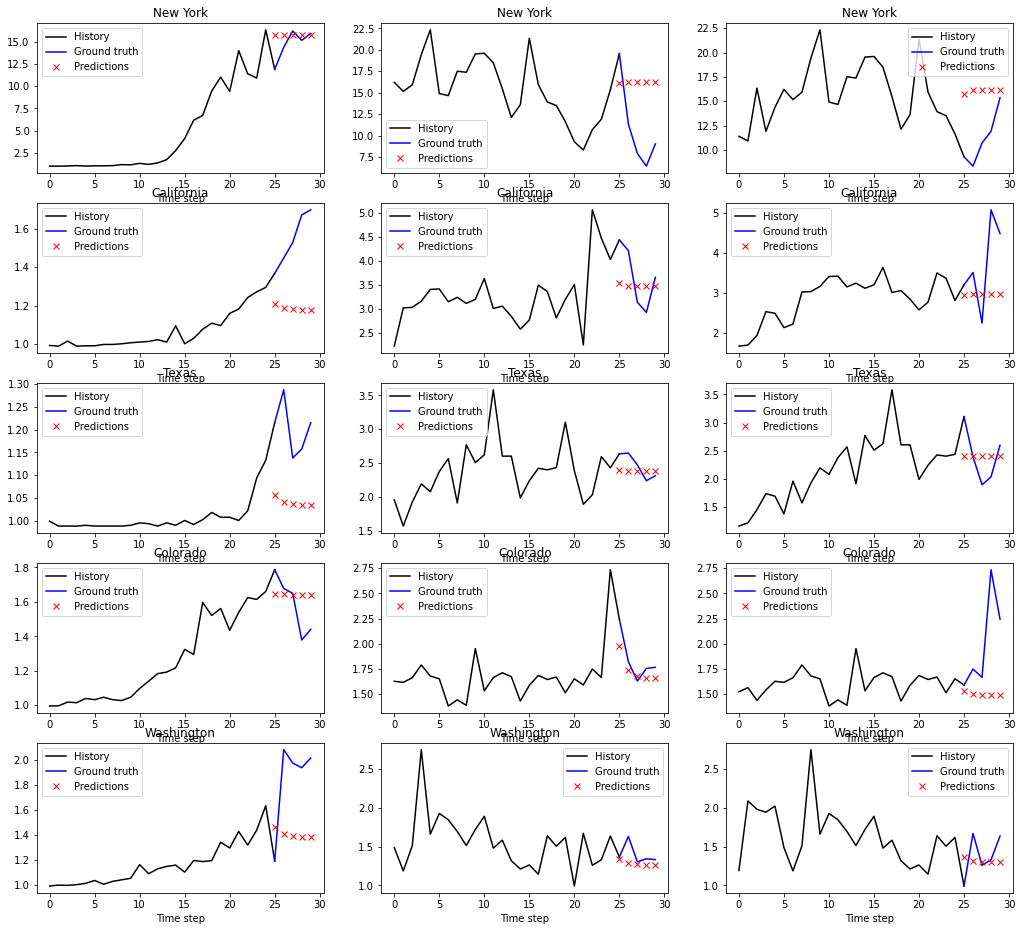

In [19]:
plot_example_states(states, seq2seq_covid_scratch, data_dict_covid, scaler_covid)

This seems better than the COVID-from-scratch model, but not great still. Maybe we can take advantage of TL to improve performance.

### Fine-tuning just the head (transfer learning)

To perform TL, we use a custom-written method in the `Seq2Seq` class: `transfer()`. This method creates a new `Seq2Seq` object with all the trained weights copied over. As well, we can specify that we want the weights frozen except for the FCN head.

In [20]:
seq2seq_covid_finetune = seq2seq_model.transfer(freeze=True)
seq2seq_covid_finetune.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 16), (No 1152        input_9[0][0]                    
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 25, 16), (No 2112        encoder_lstm0[0][0]              
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 32)           0           encoder_lstm1[0][1]              
                                                                 encoder_lstm1[0][2]        

Notice how many fewer parameters we have to train! We went from over 5,000 to closer to 250!

Train for 14 steps, validate for 4 steps
Epoch 1/20
14/14 [==============================] - 6s 453ms/step - loss: 0.4512 - val_loss: 0.1083
Epoch 2/20
14/14 [==============================] - 1s 37ms/step - loss: 0.3482 - val_loss: 0.0890
Epoch 3/20
14/14 [==============================] - 1s 44ms/step - loss: 0.2719 - val_loss: 0.0935
Epoch 4/20
14/14 [==============================] - 1s 52ms/step - loss: 0.2275 - val_loss: 0.1144
Epoch 5/20
14/14 [==============================] - 1s 47ms/step - loss: 0.1988 - val_loss: 0.1066
Epoch 6/20
14/14 [==============================] - 1s 47ms/step - loss: 0.1745 - val_loss: 0.1463
Epoch 7/20
14/14 [==============================] - 1s 50ms/step - loss: 0.1588 - val_loss: 0.1260
Epoch 8/20
14/14 [==============================] - 1s 48ms/step - loss: 0.1511 - val_loss: 0.1240
Epoch 9/20
14/14 [==============================] - 1s 43ms/step - loss: 0.1443 - val_loss: 0.1346
Epoch 10/20
14/14 [==============================] - 1s 40ms/step -

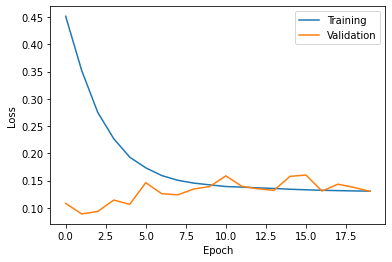

In [21]:
history_cov_finetune = seq2seq_covid_finetune.fit(ds_train_covid, validation_data=ds_val_covid, epochs=EPOCHS)
plotting.plot_history(history_cov_finetune)

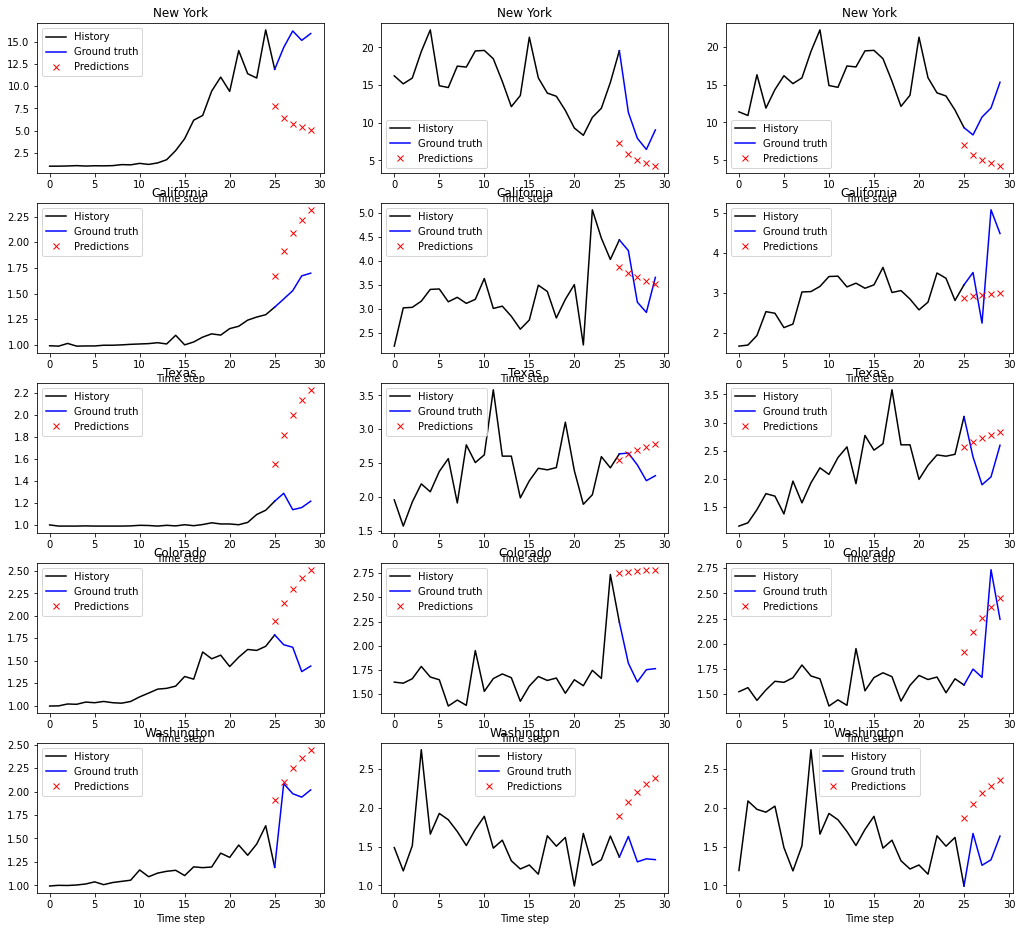

In [22]:
plot_example_states(states, seq2seq_covid_finetune, data_dict_covid, scaler_covid)

### Fine-tuning the entire network

Finally we can see whether we are able to fine-tune the entire network for the task of predicting COVID-19. One major reason why this is unlikely to work is because the COVID dataset is much smaller than the flu dataset, whereas the network is more in proportion to the flu dataset in terms of the total number of weights.

In [23]:
seq2seq_covid_tuneall = seq2seq_model.transfer(freeze=False)
seq2seq_covid_tuneall.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 16), (No 1152        input_17[0][0]                   
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 25, 16), (No 2112        encoder_lstm0[0][0]              
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 32)           0           encoder_lstm1[0][1]              
                                                                 encoder_lstm1[0][2]       

Train for 14 steps, validate for 4 steps
Epoch 1/20
14/14 [==============================] - 6s 407ms/step - loss: 0.2839 - val_loss: 0.0958
Epoch 2/20
14/14 [==============================] - 1s 39ms/step - loss: 0.1351 - val_loss: 0.1014
Epoch 3/20
14/14 [==============================] - 0s 32ms/step - loss: 0.1216 - val_loss: 0.1043
Epoch 4/20
14/14 [==============================] - 0s 35ms/step - loss: 0.1138 - val_loss: 0.1081
Epoch 5/20
14/14 [==============================] - 0s 32ms/step - loss: 0.1085 - val_loss: 0.1022
Epoch 6/20
14/14 [==============================] - 0s 33ms/step - loss: 0.1073 - val_loss: 0.0984
Epoch 7/20
14/14 [==============================] - 0s 34ms/step - loss: 0.1030 - val_loss: 0.0984
Epoch 8/20
14/14 [==============================] - 0s 32ms/step - loss: 0.1017 - val_loss: 0.1224
Epoch 9/20
14/14 [==============================] - 0s 33ms/step - loss: 0.1014 - val_loss: 0.0950
Epoch 10/20
14/14 [==============================] - 0s 33ms/step -

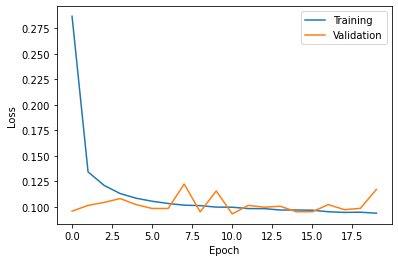

In [24]:
history_cov_tuneall = seq2seq_covid_tuneall.fit(ds_train_covid, validation_data=ds_val_covid, epochs=EPOCHS)
plotting.plot_history(history_cov_tuneall)

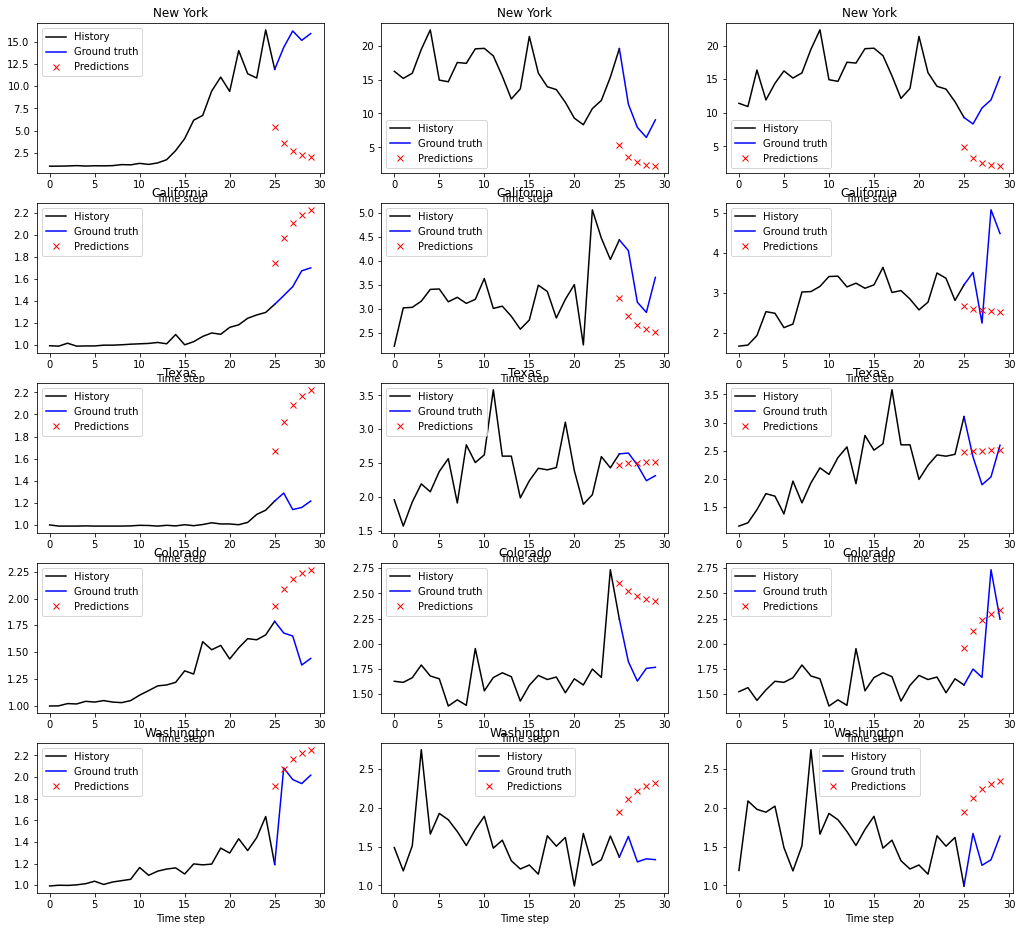

In [25]:
plot_example_states(states, seq2seq_covid_tuneall, data_dict_covid, scaler_covid)

Superficially, it looks like the fine-tuned model performed best! (Although "best" is a relative term)

### Comparing models

We can look at the RMSE of the different COVID-19 models to see whether TL admits any advantage (although it might not seem like it from the figures)

In [26]:
X_test = data_dict_covid['X_test']
y_test = data_dict_covid['y_test']
seq2seq_models = [seq2seq_model, seq2seq_covid_scratch, seq2seq_covid_finetune, seq2seq_covid_scratch]
names = ['Base flu model', 'Base COVID model', 'Fine-tuned', 'Full tuned']
rmses = []
for model in seq2seq_models:
    rmse = utils.calc_rmse_model(y_test, X_test, model, scaler_covid)
    rmses.append(rmse)

In [27]:
df_rmse = pd.DataFrame({
    'Model': names,
    'RMSE': rmses
}).set_index('Model')
df_rmse

,RMSE
Model,
Base flu model,1260.121594
Base COVID model,1754.479592
Fine-tuned,887.328828
Full tuned,1754.479592


## Other ways to improve the models

In this section, we will briefly cover several possible improvements to the models. In short, the improvements are:

1. Training the flu model on a dataset resampled to daily, rather than weekly frequency
2. Adding state-specific tags (state embeddings)

#### Resampling

In [28]:
# Resampling the flu data to be daily resolution
from datetime import datetime, timedelta

def parse_date(d):
    yy, ww = d.split('-')
    ystart = datetime(year=int(yy), month=1, day=1)
    dd = ystart + timedelta(days=7 * int(ww))
    return dd


df_flu_res = df_flu.copy()
df_flu_res['time'] = df_flu_res['time'].apply(parse_date)
df_flu_res = df_flu_res.set_index(pd.DatetimeIndex(df_flu_res['time'])).drop('time', axis=1)
df_flu_res = df_flu_res.groupby('state').apply(lambda group: (group
                                                              .resample('D')
                                                              .interpolate(method='linear')))
df_flu_res = df_flu_res.drop('state', axis=1).reset_index()

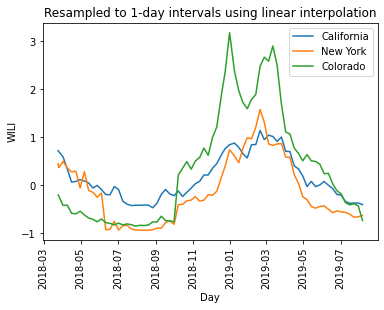

In [29]:
for state in ['California', 'New York', 'Colorado']:
    plt.plot(df_flu_res[df_flu_res['state'] == state]['time'][-500:], df_flu_res[df_flu_res['state'] == state]['wili'][-500:], label=state)
plt.legend()
plt.title("Resampled to 1-day intervals using linear interpolation")
plt.xlabel("Day")
plt.ylabel("WILI")
plt.xticks(rotation=90)
plt.show()

In [30]:
ds_train_flu_res, ds_val_flu_res, ds_test_flu_res, data_dict_flu_res = \
    time_series.prepare_data(df_flu_res['wili'].values, 
                             df_flu_res['state'].values,
                             history_size=HISTORY_SIZE,
                             target_size=TARGET_SIZE,
                             batch_size=BATCH_SIZE,
                             test_size=TEST_SIZE,
                             teacher_forcing=True)

In [31]:
seq2seq_flu_res = models.Seq2Seq(history_length=HISTORY_SIZE,
                                 target_length=TARGET_SIZE,
                                 hidden_size=HIDDEN_SIZE,
                                 pre_output_dense_size=PRE_OUTPUT_DENSE_SIZE,
                                 num_encoder_layers=NUM_ENCODER_LAYERS)
seq2seq_flu_res.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 16), (No 1152        input_25[0][0]                   
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 25, 16), (No 2112        encoder_lstm0[0][0]              
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 32)           0           encoder_lstm1[0][1]              
                                                                 encoder_lstm1[0][2]       

In [32]:
history_flu_res = seq2seq_flu_res.fit(ds_train_flu_res, validation_data=ds_val_flu_res, epochs=5)

Train for 1747 steps, validate for 375 steps
Epoch 1/5
1747/1747 [==============================] - 62s 35ms/step - loss: 0.0764 - val_loss: 0.0021
Epoch 2/5
1747/1747 [==============================] - 60s 35ms/step - loss: 0.0025 - val_loss: 9.6453e-04
Epoch 3/5
1747/1747 [==============================] - 57s 33ms/step - loss: 0.0012 - val_loss: 6.3086e-04
Epoch 4/5
1747/1747 [==============================] - 63s 36ms/step - loss: 8.9964e-04 - val_loss: 5.0624e-04
Epoch 5/5
1747/1747 [==============================] - 57s 33ms/step - loss: 8.0780e-04 - val_loss: 4.6022e-04


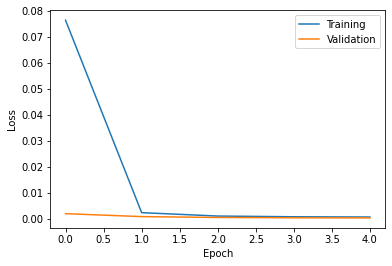

In [33]:
plotting.plot_history(history_flu_res)

In [34]:
seq2seq_covid_res = seq2seq_flu_res.transfer(freeze=True)
seq2seq_covid_res.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 16), (No 1152        input_29[0][0]                   
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 25, 16), (No 2112        encoder_lstm0[0][0]              
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 32)           0           encoder_lstm1[0][1]              
                                                                 encoder_lstm1[0][2]       

In [35]:
history_covid_res = seq2seq_covid_res.fit(ds_train_covid, validation_data=ds_val_covid, epochs=EPOCHS)

Train for 14 steps, validate for 4 steps
Epoch 1/20
14/14 [==============================] - 6s 462ms/step - loss: 0.1761 - val_loss: 0.1798
Epoch 2/20
14/14 [==============================] - 1s 37ms/step - loss: 0.1743 - val_loss: 0.1816
Epoch 3/20
14/14 [==============================] - 1s 37ms/step - loss: 0.1727 - val_loss: 0.1785
Epoch 4/20
14/14 [==============================] - 1s 37ms/step - loss: 0.1678 - val_loss: 0.1801
Epoch 5/20
14/14 [==============================] - 1s 38ms/step - loss: 0.1656 - val_loss: 0.1488
Epoch 6/20
14/14 [==============================] - 0s 35ms/step - loss: 0.1633 - val_loss: 0.1557
Epoch 7/20
14/14 [==============================] - 0s 35ms/step - loss: 0.1551 - val_loss: 0.1535
Epoch 8/20
14/14 [==============================] - 0s 35ms/step - loss: 0.1552 - val_loss: 0.1697
Epoch 9/20
14/14 [==============================] - 0s 35ms/step - loss: 0.1555 - val_loss: 0.1371
Epoch 10/20
14/14 [==============================] - 0s 35ms/step -

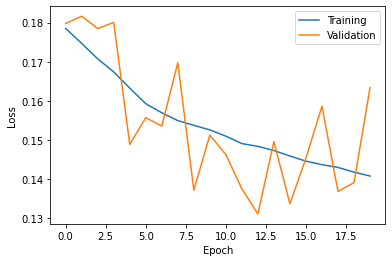

In [36]:
plotting.plot_history(history_covid_res)

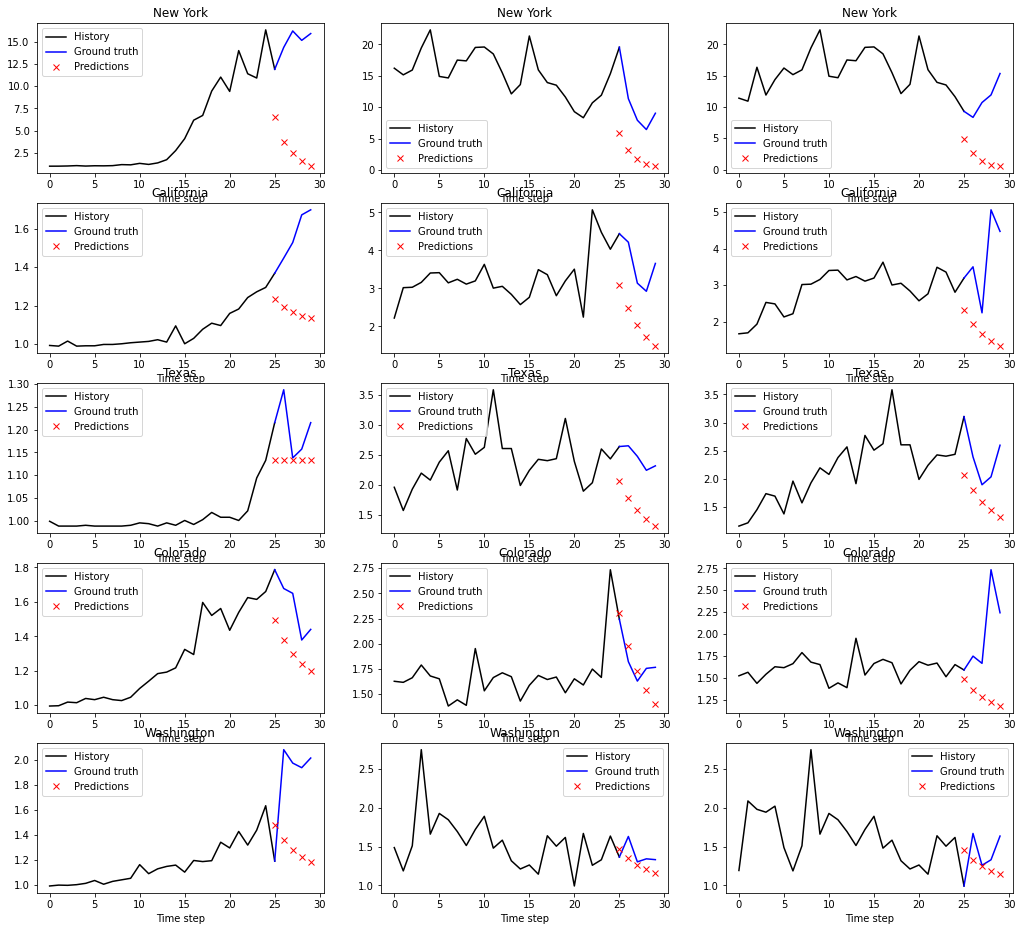

In [37]:
plot_example_states(states, seq2seq_covid_res, data_dict_covid, scaler_covid)

In [38]:
# Computing RMSE
rmses.append(utils.calc_rmse_model(y_test, X_test, seq2seq_covid_res, scaler_covid))
names.append('Resampled')

### Using state information

Until now, we have been treating each state's time series as if it is drawn from the same distribution, conditioned on the observed history:

$$y_t \sim P(y|y_{1:t-1})$$

where $y_t$ is the next predicted point in the time series, and $y_{t:t-1}$ is the observed history of length $H$ (in our case, 25). However, it should be clear from the existing plots of both COVID and flu that the states behave quite differently. For instance, New York's COVID-19 outbreak is famously different from that of the other states. In order to account for this, we will attempt to condition the model on the state that is being predicted:

$$
y_t \sim P(y|y_{1:t-1}, s)
$$

where $s$ is the state that the time series is taken from. Similar to the homework on conditional variational autoencoders (CVAEs), we will add this information to the encoded representation of the time series in the form of an *embedding*. This will be accomplished using Keras' **Embedding** layer, which conveniently maps from an index of a categorical variable to a fixed-length dense vector. This vector is then concatenated to the final cell and hidden states of the encoder LSTM, passed through a dense layer, and used to initialize the hidden state of the decoder RNN.

#### Preparing state data

In [39]:
# Making train/val/test split
# Adding *_s for "state"
ds_train_flu_s, ds_val_flu_s, ds_test_flu_s, data_dict_flu_s = \
    time_series.prepare_data(df_flu['wili'].values, 
                             df_flu['state'].values,
                             history_size=HISTORY_SIZE,
                             target_size=TARGET_SIZE,
                             batch_size=BATCH_SIZE,
                             test_size=TEST_SIZE,
                             teacher_forcing=True,
                             states=True)

ds_train_covid_s, ds_val_covid_s, ds_test_covid_s, data_dict_covid_s = \
time_series.prepare_data(df_covid['cases'].values, 
                         df_covid['state'].values,
                         history_size=HISTORY_SIZE,
                         target_size=TARGET_SIZE,
                         batch_size=BATCH_SIZE,
                         test_size=TEST_SIZE,
                         teacher_forcing=True,
                         states=True)

In [40]:
seq2seq_flu_s = models.Seq2Seq(history_length=HISTORY_SIZE,
                               target_length=TARGET_SIZE,
                               hidden_size=HIDDEN_SIZE,
                               pre_output_dense_size=PRE_OUTPUT_DENSE_SIZE,
                               num_encoder_layers=NUM_ENCODER_LAYERS,
                               state_embed_size=32)
seq2seq_flu_s.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 16), (No 1152        input_37[0][0]                   
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        1696        input_38[0][0]                   
___________________________________________________________________________________________

In [41]:
history_flu_s = seq2seq_flu_s.fit(ds_train_flu_s, validation_data=ds_val_flu_s, epochs=EPOCHS)

Train for 236 steps, validate for 51 steps
Epoch 1/20
236/236 [==============================] - 14s 60ms/step - loss: 0.2851 - val_loss: 0.1273
Epoch 2/20
236/236 [==============================] - 8s 34ms/step - loss: 0.1090 - val_loss: 0.0936
Epoch 3/20
236/236 [==============================] - 8s 33ms/step - loss: 0.0974 - val_loss: 0.0927
Epoch 4/20
236/236 [==============================] - 8s 33ms/step - loss: 0.0952 - val_loss: 0.0885
Epoch 5/20
236/236 [==============================] - 8s 35ms/step - loss: 0.0938 - val_loss: 0.0948
Epoch 6/20
236/236 [==============================] - 8s 33ms/step - loss: 0.0926 - val_loss: 0.0993
Epoch 7/20
236/236 [==============================] - 8s 36ms/step - loss: 0.0923 - val_loss: 0.1017
Epoch 8/20
236/236 [==============================] - 9s 37ms/step - loss: 0.0905 - val_loss: 0.1098
Epoch 9/20
236/236 [==============================] - 8s 35ms/step - loss: 0.0901 - val_loss: 0.0987
Epoch 10/20
236/236 [==========================

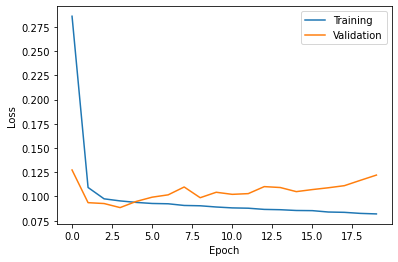

In [42]:
plotting.plot_history(history_flu_s)

In [43]:
state2idx = {s: i for i, s in enumerate(np.unique(df_flu['state']))}

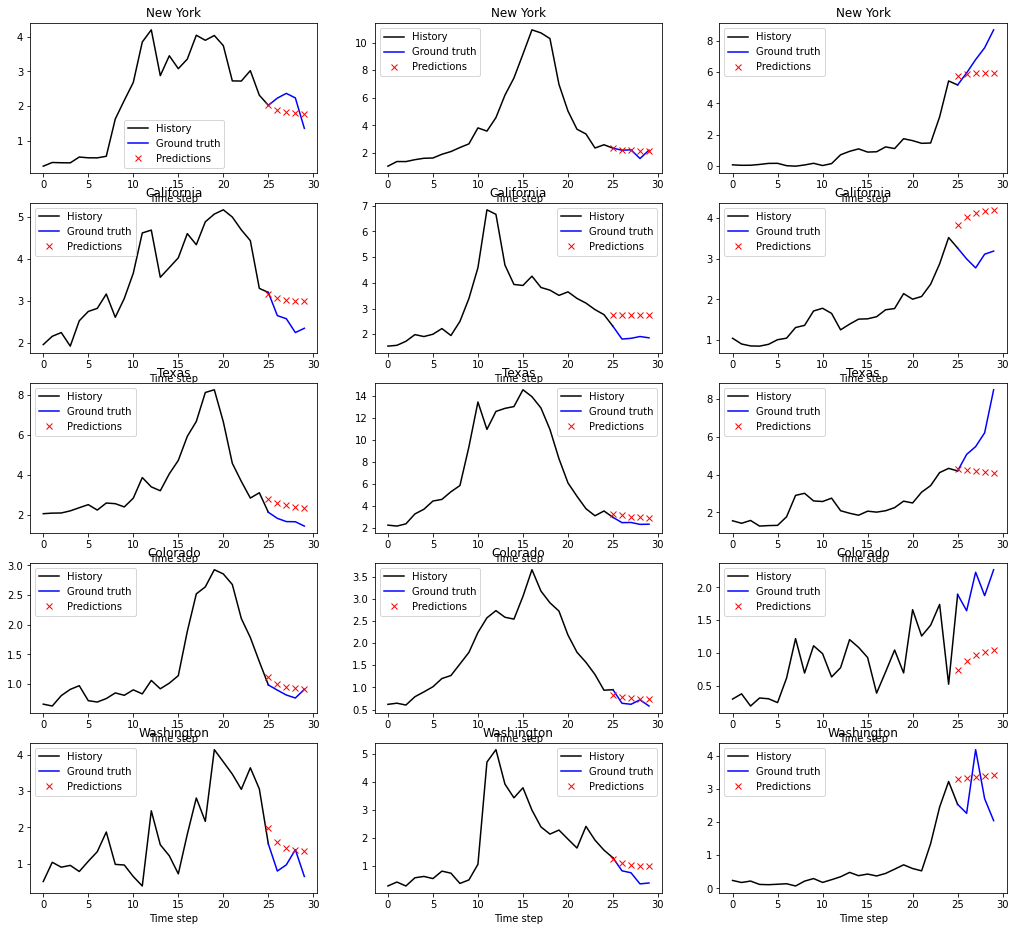

In [44]:
plot_example_states(states, seq2seq_flu_s, data_dict_flu_s, scaler_flu, state2idx=state2idx)

#### Examining the embeddings

Just like word or attribute embeddings, it might be worthwhile to examine these embeddings to see if any interesting patterns can be uncovered.

In [45]:
embeds = []
for state, idx in state2idx.items():
    embed = seq2seq_flu_s.state_embed_model(np.array([[idx]]))
    embeds.append(embed.numpy().flatten())
embeds = np.stack(embeds, 0)

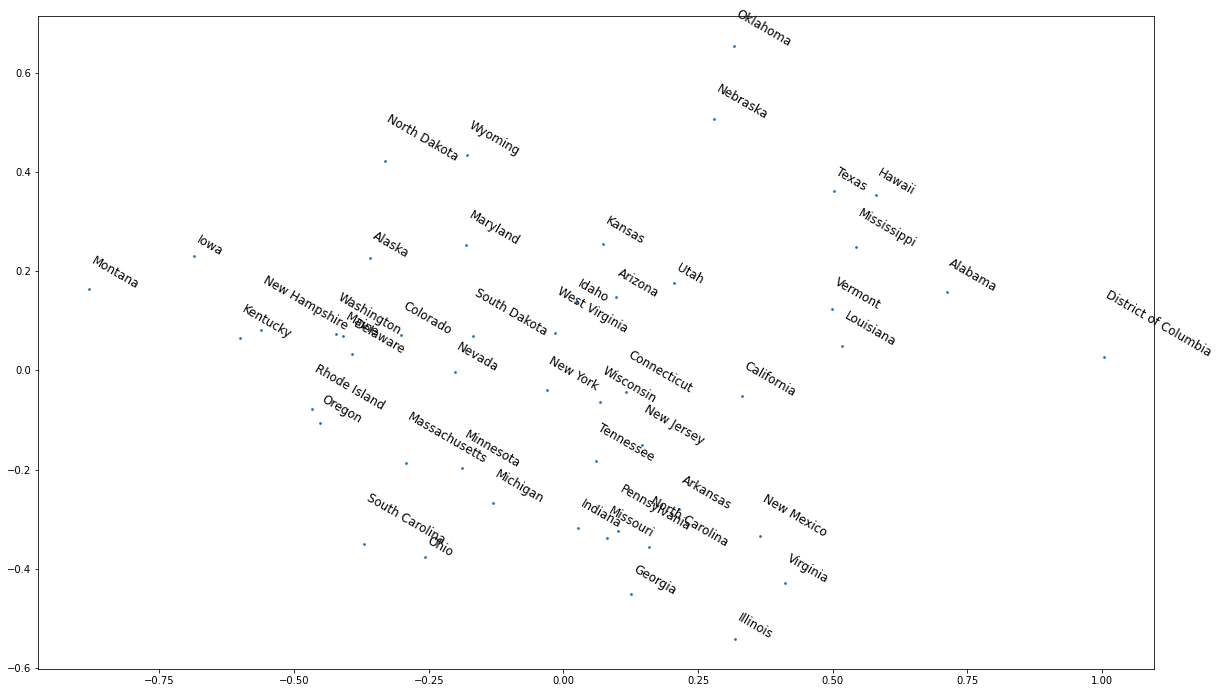

In [46]:
# PCA clustering
pca = PCA(n_components=2)
embeds_pca = pca.fit_transform(embeds)

plt.figure(figsize=(20, 12))
plt.scatter(embeds_pca[:, 0], embeds_pca[:, 1], s=3)
for state, idx in state2idx.items():
    plt.annotate(state, (embeds_pca[idx, 0], embeds_pca[idx, 1]), rotation=-30, size=12)

However, since the embeddings did not overtly affect the model predictions, it's safe to say that in this particular instance, the embeddings are likely *not* capturing much of interest. Future work could examine how conditioning on country/state or other knowledge of the real world could improve performance. For instance, using facts about a state that we know affect transmission, such as mobility or density, might lead to a performance gain, provided the base model is appropriate. Unfortunately, it is unclear whether the base model is indeed appropriate in this case, meaning that we would first need to focus on improving the model before adding more features to it!

## Conclusion

Again, here are all the RMSE's for the models:

In [47]:
df_rmse = pd.DataFrame({
    'Model': names,
    'RMSE': rmses
}).set_index('Model')
df_rmse

,RMSE
Model,
Base flu model,1260.121594
Base COVID model,1754.479592
Fine-tuned,887.328828
Full tuned,1754.479592
Resampled,1155.265275


We can see that while no single model yielded particularly impressive results that rival any of the state of the art epidemiological models, using the flu time series to pre-train the seq2seq model does in fact yield a performance gain over just training on COVID alone! Furthermore, freezing the base and just fine-tuning the head is significantly better than full retraining, supporting our hypothesis that reducing the number of parameters to train helps the model a lot!

Next steps in this work include

* Improving the model to reduce parameters as much as possible
* Changing the way the datasets are prepared so that there is a greater variety of trends, perhaps incorporating datasets from epidemics whose curves more closely match COVID-19
* Attempting to simultaneously forecast all states/territories, while also feeding in those states to the model as a single vector, giving the model access to more information at each time step
* Using attention to allow the model to use information from further back in the time series. This might be more useful for a seasonal disease like flu (although as seen in the other notebook, this did not improve the performance of our models)